In [1]:
import os
import sys
import numpy as np
import pandas as pd
import tensorflow.keras.utils as utils
from sklearn.metrics import (accuracy_score, f1_score)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import time

In [2]:
import tensorflow as tf
from keras.applications.vgg19 import VGG19
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dropout
from keras.models import Model
from keras.utils import plot_model
from keras import Input

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import zipfile

zip_path = '/content/drive/MyDrive/eyepacs_preprocess.zip'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/data/')

In [5]:
import cv2
def image_preprocessing(img):
    # 1. Read the image
    img = img.astype(np.uint8)
    
    # 2. Extract the green channel of the image
    b, g, r = cv2.split(img)
    
    # 3.1. Apply CLAHE to intensify the green channel extracted image
    clh = cv2.createCLAHE(clipLimit=4.0)
    g = clh.apply(g)
    
    # 3.2. Convert enhanced image to grayscale
    merged_bgr_green_fused = cv2.merge((b, g, r))
    img_bw = cv2.cvtColor(merged_bgr_green_fused, cv2.COLOR_BGR2GRAY)
    
    # 4. Remove the isolated pixels using morphological cleaning operation.
    kernel1 = np.ones((1, 1), np.uint8)
    morph_open = cv2.morphologyEx(img_bw, cv2.MORPH_OPEN, kernel1)
    
    # 5. Extract blood vessels using mean-C thresholding.
    thresh = cv2.adaptiveThreshold(morph_open, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 9, 5)
    
    # 6. Applying morph_open operation
    kernel2 = np.ones((2, 2), np.uint8)
    morph_open2 = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel2)
    
    # 6. Stacking the image into 3 channels
    stacked_img = np.stack((morph_open,)*3, axis=-1)
    
    return stacked_img.astype("float64")

In [37]:
# from keras.callbacks import ReduceLROnPlateau, EarlyStopping
# from sklearn.utils.class_weight import compute_class_weight

# def train_classifier(train_data, valid_data, train_set, valid_set):
#     model = Sequential()
#     model.add(Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=(224, 224, 3)))
#     model.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
#     model.add(MaxPooling2D(pool_size=2))

#     model.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
#     model.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
#     model.add(MaxPooling2D(pool_size=2))

#     model.add(Flatten())
#     model.add(Dense(256, activation='relu'))
#     model.add(Dropout(0.5))

#     model.add(Dense(5, activation='softmax'))

#     model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#     lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, mode='min')
#     early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min')

#     # unique_classes = np.unique(train_set['level'])
#     # class_weights = compute_class_weight('balanced', classes=unique_classes, y=train_set['level'])
#     # class_weights_dict = {i: class_weights[i] for i, class_name in enumerate(unique_classes)}
#     # print(class_weights_dict)

#     num_train_samples = len(train_set)
#     num_valid_samples = len(valid_set)
#     batch_size = 32
    
#     model.fit(train_data,
#               steps_per_epoch=num_train_samples // batch_size,
#               epochs=50,
#               verbose=1,
#               validation_data=valid_data,
#               validation_steps=num_valid_samples // batch_size,
#               callbacks=[early_stopping, lr_scheduler],
#               shuffle=True)

#     # plot_model(model, show_shapes=True, to_file='model_S.png')

#     return model

In [6]:
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
# from sklearn.utils.class_weight import compute_class_weight
import numpy as np

def train_classifier(train_data, valid_data, train_set, valid_set):
    base_model = VGG19(weights="imagenet", include_top=False)
    true_input = Input(shape=(224,224,3))
    x = base_model(true_input)
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x= Dropout(0.5)(x)
    predictions = Dense(5, activation='softmax')(x)
    for layer in base_model.layers:
        layer.trainable = False
    model = Model(inputs=true_input, outputs=predictions)

    # optimizer = tf.keras.optimizers.Adam(clipnorm=1.0)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, mode='min')
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min')

    # unique_classes = np.unique(train_set['level'])
    # class_weights = compute_class_weight('balanced', classes=unique_classes, y=train_set['level'])
    # class_weights_dict = {i: class_weights[i] for i, class_name in enumerate(unique_classes)}
    # print(class_weights_dict)

    num_train_samples = len(train_set)
    num_valid_samples = len(valid_set)
    batch_size = 32
    
    model.fit(train_data,
              steps_per_epoch=num_train_samples // batch_size,
              epochs=50,
              verbose=1,
              validation_data=valid_data,
              validation_steps=num_valid_samples // batch_size,
              callbacks=[early_stopping, lr_scheduler],
              shuffle=True)

    plot_model(model, show_shapes=True, to_file='model_V.png')
    return model

In [7]:
def compute_metrics(ground, pred):    
    scores = {}
    scores["accuracy"] = accuracy_score(y_true=ground, y_pred=pred)
    scores["f1"] = f1_score(y_true=ground, y_pred=pred, average="macro")
    return scores

In [8]:
def perform_alL_evaluation_on_one_model(model, all_data):
    predictions = model.predict(all_data, verbose=1)
    prediction = np.argmax(predictions, axis=1)

    nothing = np.count_nonzero(prediction == 2)
    mild = np.count_nonzero(prediction == 0)
    moderate = np.count_nonzero(prediction == 1)
    severe = np.count_nonzero(prediction == 4)
    proliferate = np.count_nonzero(prediction == 3)  

    print('Nothing: ' + str(nothing))
    print('Mild: ' + str(mild))
    print('Moderate: ' + str(moderate))
    print('Severe: ' + str(severe))
    print('Proliferate: ' + str(proliferate))
    
    return prediction  

In [9]:
def make_predictions(model_test, valid_data):
    # Evaluate the model
    predictions = model_test.predict(valid_data, verbose=1)
    y_preds = np.argmax(predictions, axis=1)
    return y_preds

In [10]:
import matplotlib.pyplot as plt

def plot_result(hist):
    plt.figure(figsize=(20, 10));
    plt.suptitle(f"Performance Metrics", fontsize=20)
    
    # Actual and validation losses
    plt.subplot(1, 2, 1);
    plt.plot(hist['loss'], label='train')
    plt.plot(hist['val_loss'], label='validation')
    plt.title('Train and val loss curve')
    plt.legend()

    # Actual and validation accuracy
    plt.subplot(1, 2, 2);
    plt.plot(hist['accuracy'], label='train')
    plt.plot(hist['val_accuracy'], label='validation')
    plt.title('Train and val accuracy curve')
    plt.legend()

In [11]:
def half(x):
    if x['level'].iloc[0] == 'Nothing':
        return x.sample(frac=0.25)
    else:
        return x

In [12]:
def create_class_generator(dataframe, class_name, aug_params, seed=42):
    datagen = ImageDataGenerator(rescale=1./255, preprocessing_function=image_preprocessing, **aug_params)
    class_data = dataframe[dataframe['level'] == class_name]
    return datagen.flow_from_dataframe(
        dataframe=class_data,
        directory="/content/data/eyepacs_preprocess",
        x_col='image',
        y_col='level',
        class_mode="categorical",
        batch_size=32,
        seed=seed,
        target_size=(224, 224)
    )

In [13]:
from functools import reduce

def combined_generator(generators):
    while True:
        data_batch = [next(gen) for gen in generators]
        x_batch = reduce(lambda x1, x2: np.concatenate((x1, x2), axis=0), [d[0] for d in data_batch])
        y_batch = reduce(lambda y1, y2: np.concatenate((y1, y2), axis=0), [d[1] for d in data_batch])
        yield x_batch, y_batch

In [ ]:
    from google.colab import files
    import random

    # Import database
    # Set path to the EyePACS dataset
    # data_dir = "./eyepacs_preprocess"
    data_dir = "/content/data"

    labels = pd.read_csv("/content/drive/MyDrive/trainLabels (1).csv")
    labels['image'] = [i[1]['image']+'.jpeg' for i in labels.iterrows()]
    class_counts = labels['level'].value_counts()
    print('Original:')
    print(class_counts)

    # Half the number of Nothing diagnosis
    # reduced_labels = labels.groupby('level', group_keys=False).apply(half).reset_index(drop=True)
    # reduced_labels.to_csv("/content/drive/MyDrive/reduced_trainLabels.csv", index=False)
    # new_class_counts = reduced_labels['level'].value_counts()
    # print('Evened out:')
    # print(new_class_counts)

    # Split into training a validation sets
    train_set = {}
    valid_set = {}
    classes=['Nothing','Mild','Moderate','Severe','Proliferate']
    for i in range(5):
        temp = labels[labels['level']==classes[i]]['image'].to_list()
        random.seed(42)
        x = random.sample(temp, int(0.75*len(temp)))
        for j in x:
            train_set[j] = classes[i]
        for j in temp:
            if j not in train_set.keys():
                valid_set[j] = classes[i]

    train_set = pd.DataFrame(train_set.items(), columns=['image', 'level']).sample(frac=1, random_state=42)
    train_set_counts = train_set['level'].value_counts()
    print('Training data:')
    print(train_set_counts)

    valid_set = pd.DataFrame(valid_set.items(), columns=['image', 'level']).sample(frac=1, random_state=42)
    valid_set_counts = valid_set['level'].value_counts()
    print('Validation data:')
    print(valid_set_counts)

    # augmentation_settings = {
    #     'Nothing': {'rotation_range': 0, 'width_shift_range': 0, 'height_shift_range': 0, 'zoom_range': 0},
    #     'Mild': {'rotation_range': 0, 'width_shift_range': 0, 'height_shift_range': 0, 'zoom_range': 0},
    #     'Moderate': {'rotation_range': 10, 'width_shift_range': 0.1, 'height_shift_range': 0.1, 'zoom_range': 0.1},
    #     'Severe': {'rotation_range': 20, 'width_shift_range': 0.2, 'height_shift_range': 0.2, 'zoom_range': 0.2},
    #     'Proliferate': {'rotation_range': 20, 'width_shift_range': 0.2, 'height_shift_range': 0.2, 'zoom_range': 0.2},
    # }

    # train_generators = [create_class_generator(train_set, class_name, aug_params) for class_name, aug_params in augmentation_settings.items()]


    # # Define data generators for training and validation sets
    # train_data = combined_generator(train_generators)

    training_datagen = ImageDataGenerator(rescale = 1./255,
                                            preprocessing_function = image_preprocessing)

    train_data = training_datagen.flow_from_dataframe(dataframe=train_set, 
                                                    directory=data_dir + "/eyepacs_preprocess",
                                                    x_col='image',
                                                    y_col='level',
                                                    class_mode="categorical",
                                                    batch_size=32,
                                                    seed=42,
                                                    target_size=(224,224))

    validation_datagen = ImageDataGenerator(rescale = 1./255,
                                            preprocessing_function = image_preprocessing)

    valid_data = validation_datagen.flow_from_dataframe(dataframe=valid_set, 
                                                    directory=data_dir + "/eyepacs_preprocess",
                                                    x_col='image',
                                                    y_col='level',
                                                    class_mode="categorical",
                                                    batch_size=32,
                                                    seed=42,
                                                    target_size=(224,224))
    
    print(valid_data.class_indices)
    
    # Set up timing dictionary
    all_times = {}
        
    # # Train classifiers
    start_time = time.time()
    print("Training " + "NN" + "...")
    model = train_classifier(train_data, valid_data, train_set, valid_set)
    print("Training complete!")
    all_times["TRAINING"] = time.time() - start_time
    
    # Evaluate
    start_time = time.time()
    results = model.evaluate(valid_data, batch_size=32)
    print(results)
    prediction = perform_alL_evaluation_on_one_model(model, valid_data)
    all_times["EVALUATION"] = time.time() - start_time

    model.save('DR_Detection_2.h5') 

    # Print and save metrics
    # print_results(model, model_metrics, all_times)
    # with open(out_dir + "/" + "sequential_NN" + "_RESULTS.txt", "w") as f:
    #     print_results(model, model_metrics, all_times, stream=f)
    # files.download('Results.txt')

Original:
Nothing        25802
Moderate        5288
Mild            2438
Severe           872
Proliferate      708
Name: level, dtype: int64
Training data:
Nothing        19351
Moderate        3966
Mild            1828
Severe           654
Proliferate      531
Name: level, dtype: int64
Validation data:
Nothing        6451
Moderate       1322
Mild            610
Severe          218
Proliferate     177
Name: level, dtype: int64
Found 26330 validated image filenames belonging to 5 classes.
Found 8778 validated image filenames belonging to 5 classes.
{'Mild': 0, 'Moderate': 1, 'Nothing': 2, 'Proliferate': 3, 'Severe': 4}
Training NN...
80134624/80134624 [==============================] - 3s 0us/step
Epoch 1/50
822/822 [==============================] - 599s 711ms/step - loss: 1.0547 - accuracy: 0.7272 - val_loss: 0.8247 - val_accuracy: 0.7348 - lr: 0.0010
Epoch 2/50
822/822 [==============================] - 544s 662ms/step - loss: 0.8769 - accuracy: 0.7350 - val_loss: 0.8284 - val_accurac

In [35]:
from tensorflow.keras.models import load_model

model = load_model("DR_Detection_2.h5")

prediction = perform_alL_evaluation_on_one_model(model, train_data)

823/823 [==============================] - 378s 459ms/step
Nothing: 23674
Mild: 686
Moderate: 1668
Severe: 220
Proliferate: 82


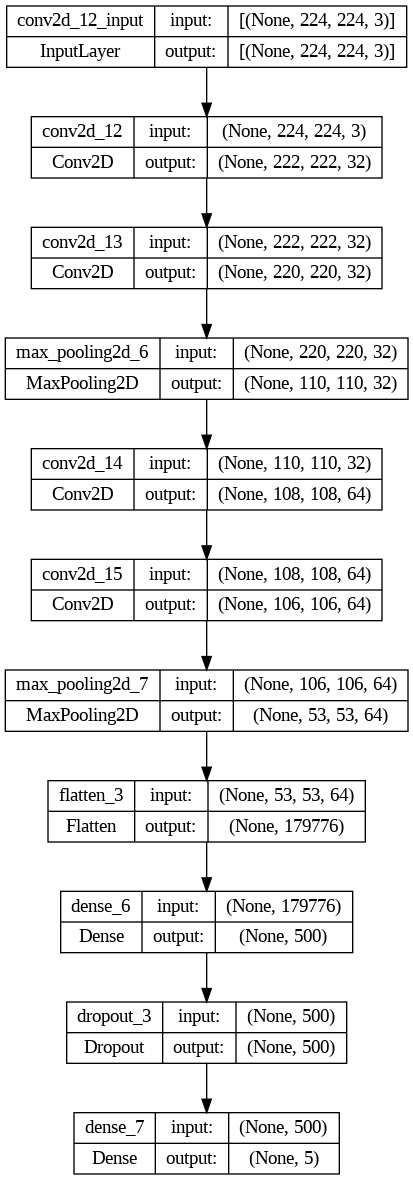

In [25]:
plot_model(model, show_shapes=True, to_file='model.png')

In [36]:
results = model.evaluate(train_data, batch_size=32)

823/823 [==============================] - 383s 465ms/step - loss: 0.4951 - accuracy: 0.8215
